# Small-strain von Mises elastoplasticity

This demo is the third installment in a series of two previous demos considering the implementation of von Mises elastoplasticity in `FEniCS` published on [Numerical tours of continuum mechanics using FEniCS](https://comet-fenics.readthedocs.io):

1. [Elasto-plastic analysis of a 2D von Mises material](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html): this first installment presents a pure `FEniCS` implementation of von Mises plasticity which uses UFL operators for implementing the return mapping procedure. It is therefore not general since it relies heavily on the fact that the return mapping can be expressed in closed-form analytic expression in the case of von Mises plasticity with linear isotropic hardening. It nevertheless shows how to integrate the constitutive relation using `Quadrature` elements, including the use of consistent tangent operators, inside a global Newton-Raphson method.


2. [Elasto-plastic analysis implemented using the `MFront` code generator](https://comet-fenics.readthedocs.io/en/latest/demo/plasticity_mfront/plasticity_mfront.py.html): this second installment is in fact the original demo which led to the development of the proposed `FEniCS`/`MFront` interface. It shows how to rely on `MFront` for the constitutive relation update using the MGIS interface. The way how information is exchanged between `FEniCS` and `MFront` in this demo is extremely similar to how the `MFrontNonlinearProblem` class is implemented.

The present demo therefore directly follows up on this second installment by offering to the use a much more compact syntax, especially avoiding the cumbersome definition of `Quadrature` spaces and the implementation of a Newton method by hand. The mechanical problem is exactly the same as in these two demos, namely the expansion of a hollow cylinder under internal pressure. The main difference in the present demo is that the same problem will also be solved in axisymmetric conditions, referring therefore to the expansion of a hollow sphere under internal pressure.

## `MFront` implementation

### Optimised implementation

In this document, we consider a $J_2$ isotropic plastic model with linear isotropic hardening. As the hardening is linear and the von Mises stress is quadratic, the behaviour integration is explicit, as described [here](http://tfel.sourceforge.net/gallery/plasticity/IsotropicLinearHardeningPlasticity.html).

The implementation used here is modified to use material properties instead of parameters. The difference between material properties and parameters is that material properties are allowed to be distinct on each integration points and may evolve over time, whereas parameters are global values.

### Usage of the `StandardElastoViscoPlasticity` brick

Another approach, less efficient in this case, is to use the [`StandardElastoViscoPlasticity` brick](http://tfel.sourceforge.net/StandardElastoViscoPlasticityBrick.html) which allows for a very compact and declarative implementation but relies on a general implicit scheme.

The advantage of using the [`StandardElastoViscoPlasticity` brick](http://tfel.sourceforge.net/StandardElastoViscoPlasticityBrick.html) is that the user may rapidely adapt this document to try more advanced plastic behaviours.

```cpp
@DSL Implicit;

@Behaviour IsotropicLinearHardeningPlasticityBrick;
@Author Thomas Helfer/Jérémy Bleyer;
@Date 07 / 04 / 2020;

@Algorithm NewtonRaphson;
@Epsilon 1.e-14;

@Theta 1.;

@MaterialProperty stress s0;
s0.setGlossaryName("YieldStress");
@MaterialProperty stress H0;
H0.setEntryName("HardeningSlope");

@Brick StandardElastoViscoPlasticity{
  stress_potential : "Hooke",
  inelastic_flow : "Plastic" {
    criterion : "Mises",
    isotropic_hardening : "Linear" {H : "H0", R0 : "s0"}
  }
};
```

Since we did not explicitely specify the values of the elastic properties, those are automatically declared as material properties. To use material properties to define yield stress and the hardening slope, one uses here a small trick, which consists in defining the material properties before the brick declaration and declare the plastic coefficients `H` and `R0` as functions of those material properties.

## `FEniCS` implementation

### Geometry

We first load the mesh and define values for the material properties. We will see later how to pass them to MFront. We will use a standard $P_2$ Lagrange interpolation for the displacement field and roller conditions are defined on the horizontal (tagged `1`) and vertical boundaries (tagged `3`) of the domain. The inner surface is tagged as `4` in the `facets` MeshFunction.

<IPython.core.display.Javascript object>


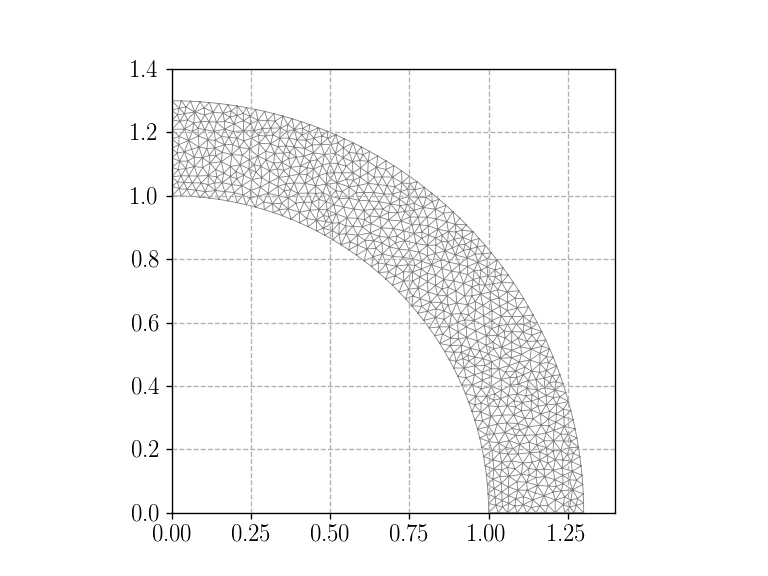

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from dolfin import *
import mgis.fenics as mf
import numpy as np
import ufl

Re, Ri = 1.3, 1.   # external/internal radius
E, nu = 70e3, 0.3  # elastic parameters
sig0 = 250.        # yield strength
Et = E/100.        # hardening slope
H = E*Et/(E-Et)

mesh = Mesh("meshes/thick_cylinder.xml")
plt.figure()
plot(mesh, linewidth=0.5)
plt.show()

facets = MeshFunction("size_t", mesh, "meshes/thick_cylinder_facet_region.xml")
ds = Measure('ds', subdomain_data=facets)


V = VectorFunctionSpace(mesh, "CG", 2)
bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
n = FacetNormal(mesh)


### Loading

We now define the loading expression which consists of a uniform internal pressure $q$ which will be progressively increased from 0 to a value slightly larger than $q_{lim}$, the analytical limit load in the case of perfect plasticity, which is known to be $q_{lim} = \dfrac{2}{\sqrt{3}}\ln\left(\dfrac{R_e}{R_i}\right)\sigma_0$ for the hollow cylinder (plane strain conditions) and $q_{lim} = 2\ln\left(\dfrac{R_e}{R_i}\right)\sigma_0$ for the hollow sphere (axisymmetric conditions) and in which $R_i$ (resp. $R_e$) denotes the internal (resp. external) radius. 

### Material

The `MFrontNonlinearMaterial` instance is loaded from the `MFront` `IsotropicLinearHardeningPlasticity` behaviour. Material properties can be defined by passing a dictionary to the `material_properties` keyword argument. Note that the keys must match the entry names defined in the `MFront` behaviour. Temperature is not involved in this behaviour so we will let it be automatically registered as a constant default value.

### Problem definition and automatic registration

The `MFrontNonlinearProblem` instance is then defined by specifying the quadrature degree used for the computation of the constitutive relation. The present computation is a standard quasi-static mechanical problem involving only the stress and strains as the pair of dual flux/gradient variables. As in the heat equation example, we should therefore register the gradient variable named `Strain` as `sym(grad(u))` in plane strain conditions. However, `Strain` is again a predefined gradient variable so that we can rely on automatic registration. This is especially efficient in the present case where the registration is different depending on the hypothesis. For the `"plane_strain"` hypothesis, we get the following message:
```
Automatic registration of 'Strain' as sym(grad(Displacement)).
```
whereas for the `"axisymmetric"` hypothesis (see [the `FEniCS` tour on axisymmetric computations](https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/axisymmetric_elasticity.html)), we get:
```
Automatic registration of 'Strain' as sym([
  [(grad(Displacement[0]))[0], (grad(Displacement[0]))[1], 0],
  [(grad(Displacement[1]))[0], (grad(Displacement[1]))[1], 0],
  [0, 0, Displacement[0] / x[0]]
]).
```
in which the first two components refer to the $r$ and $z$ directions whereas the third component refers to the out-of-plane $\theta$ direction.

The linear form corresponding to the work of external forces can be specified through the `set_loading` method, namely in the present case:

$$
W_{ext}(u) = \int_{r=R_i} -q(t)\boldsymbol{n}\cdot\boldsymbol{u} \text{ dS}
$$

Note that we pass directly the action of the form on the solution `u` rather than the linear form itself, in order to avoid the need of defining a `TestFunction`. Note also the use of the additional integration measure $2\pi r$ in the axisymmetric case.

### Load-stepping and resolution

Finally, load-stepping is done very easily by just updating the necessary expressions involved in the linear form definition (in the present case) or in the boundary conditions. At each step, the `solve` method is called on the displacement field, no updates are necessary from the user side.

State variables can also be retrieved using the `get_state_variable` method, again with names matching the entry names defined in the `MFront` behaviour. In the present case, state variables include the elastic strain (represented by a 4-dimensional vector) and the equivalent plastic strain $p$ (a scalar). The `get_state_variable` method returns a `dolfin.Function` defined on the `Quadrature` space corresponding to the problem `quadrature_degree`. Such functions must therefore be projected on function spaces suitable for visualization or other post-processing purposes, such as (DG, 0) in the present case for the equivalent plastic strain using the `project_on` optional keyword of the `get_state_variable` method.

Expansion of a thick cylinder in plane strain conditions
--------------------------------------------------------
Behaviour 'IsotropicLinearHardeningPlasticity' has not been found in './src/libBehaviour.so'.
Attempting to compile 'IsotropicLinearHardeningPlasticity.mfront' in './'...
Automatic registration of 'Strain' as sym(grad(Displacement)).

Automatic registration of 'Temperature' as a Constant value = 293.15.



<IPython.core.display.Javascript object>


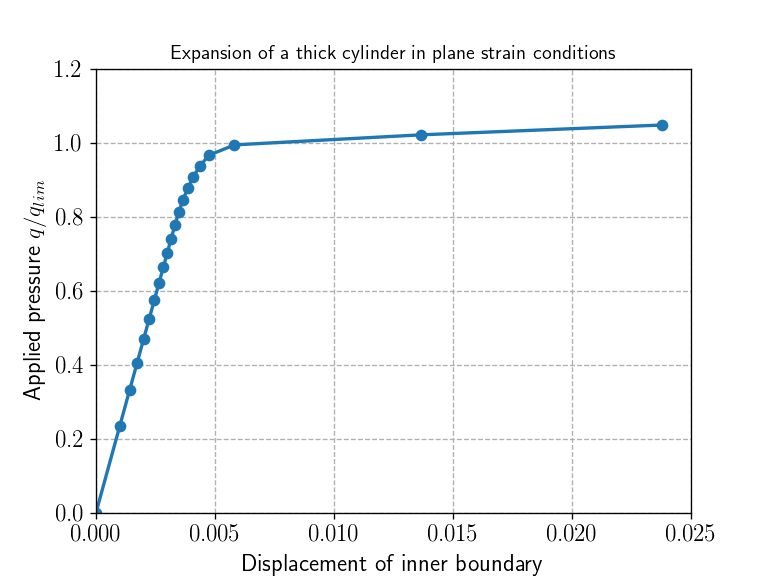

Expansion of a thick sphere in axisymmetric conditions
--------------------------------------------------------
Automatic registration of 'Strain' as sym([
  [(grad(Displacement[0]))[0], (grad(Displacement[0]))[1], 0],
  [(grad(Displacement[1]))[0], (grad(Displacement[1]))[1], 0],
  [0, 0, Displacement[0] / x[0]]
]).

Automatic registration of 'Temperature' as a Constant value = 293.15.



<IPython.core.display.Javascript object>


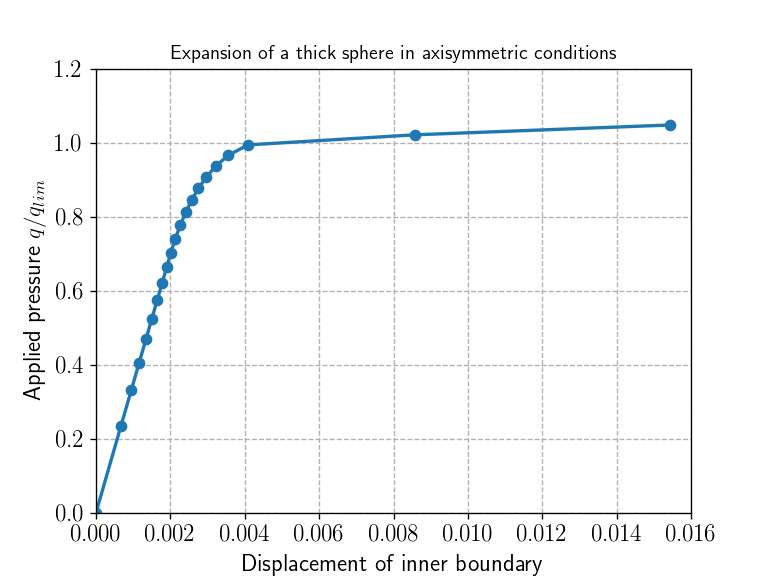

In [2]:
for hypothesis in ["plane_strain", "axisymmetric"]:
    u  = Function(V, name="Displacement")
    if hypothesis == "plane_strain":
        title = "Expansion of a thick cylinder in plane strain conditions"
        q_lim = float(2/sqrt(3)*ln(Re/Ri)*sig0)
        measure = 1
    elif hypothesis == "axisymmetric":
        title = "Expansion of a thick sphere in axisymmetric conditions"
        x = SpatialCoordinate(mesh)
        q_lim = float(2*ln(Re/Ri)*sig0)
        measure = 2*pi*abs(x[0])
    print(title + "\n"+"-"*56)
    loading = Expression("-q*t", q=q_lim, t=0, degree=2)

    mat_prop = {"YoungModulus": E,
               "PoissonRatio": nu,
               "HardeningSlope": H,
               "YieldStrength": sig0}
    material = mf.MFrontNonlinearMaterial("./src/libBehaviour.so",
                                          "IsotropicLinearHardeningPlasticity",
                                          hypothesis=hypothesis,
                                          material_properties=mat_prop)
    problem = mf.MFrontNonlinearProblem(u, material, quadrature_degree=2, bcs=bc)
    problem.set_loading(loading*dot(n, u)*measure*ds(4))

    p = problem.get_state_variable("EquivalentPlasticStrain")
    assert (ufl.shape(p) == ())
    assert (p.ufl_element().family() == "Quadrature")
    epsel = problem.get_state_variable("ElasticStrain")
    assert (ufl.shape(epsel)==(4, ))

    file_results = XDMFFile("results/plasticity_{}_results.xdmf".format(hypothesis))
    file_results.parameters["flush_output"] = True
    file_results.parameters["functions_share_mesh"] = True
    
    Nincr = 20
    load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
    results = np.zeros((Nincr+1, 2))
    for (i, t) in enumerate(load_steps):
        loading.t = t
        problem.solve(u.vector())
        p0 = problem.get_state_variable("EquivalentPlasticStrain", project_on=("DG", 0))
            
        file_results.write(u, t)
        file_results.write(p0, t)
        
        results[i+1, :] = (u(Ri, 0)[0], t)
        
    plt.figure()
    plt.title(title)
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.show()

We can check that the obtained results match those of the first two installments, both in terms of load-displacement curves, number of iterations and residual values for the plane strain case. In the axisymmetric case, we obtain similar results with plastic flow occuring at a critical pressure very close to the analytical limit load $q_{lim}$ in the perfectly plastic case.